# Optimization Project

In this Jupyter notebook, we will be using the Frank-Wolfe optimization algorithm to minimize the variance function of a portfolio in Markowitz's portfolio theory. Markowitz's theory focuses on optimizing investment portfolios by considering the trade-off between expected returns and risk. The variance function represents the risk component of the portfolio, and by minimizing it, we aim to find the optimal allocation of assets that balances risk and return. The Frank-Wolfe algorithm is an iterative optimization method that iteratively finds the direction of steepest descent to minimize the objective function. By applying this algorithm to the portfolio variance function, we can determine an efficient portfolio allocation that maximizes returns while minimizing risk. Let's dive into the details and explore the power of the Frank-Wolfe algorithm for portfolio optimization.

In [1]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from sympy import hessian
import numdifftools as nd
from datetime import datetime
import pandas as pd
import numpy as np
import scipy

In [2]:
# https://www.francescocesarone.com/data-sets
PORTFOLIOS = ["EUROSTOXX_50", "FTSE_100", "MIBTEL_295", "SP_500", "NASDAQ"] 
PORTFOLIO = PORTFOLIOS[1] #CHANGE
RISK_AVERSION = 0.02

In [3]:
# Read the text file
name = pd.read_csv(PORTFOLIO+'/data/list.txt', delimiter='\t')
price_time = np.loadtxt(PORTFOLIO+'/data/price_time.txt', delimiter='\t')
ret_time = np.loadtxt(PORTFOLIO+'/data/Ret_time.txt', delimiter='\t')
ret_mean = np.loadtxt(PORTFOLIO+'/data/MRet.txt', delimiter='\t')
cov = np.loadtxt(PORTFOLIO+'/data/Cov.txt', delimiter='\t')
time = pd.read_csv(PORTFOLIO+'/data/time.txt', delimiter='\t')

# Solution
ret_risk = pd.read_csv(PORTFOLIO+'/solutions/RetRisk_SolVal.txt', delimiter='\t')
solval_k5 = pd.read_csv(PORTFOLIO+'/solutions/K5_SolVal.txt', delimiter='\t', header=None)
try:
    solval_k10 = pd.read_csv(PORTFOLIO+'/solutions/K10_SolVal.txt', delimiter='\t', header=None)
except FileNotFoundError:
    print('File Solval_k5 non found')

# Other variable
nStocks = len(name) +1

## Portfolios Data

Portfolio: FTSE_100 
N. Stock: 79
From: 17-Mar-2003  To: 24-Mar-2008 


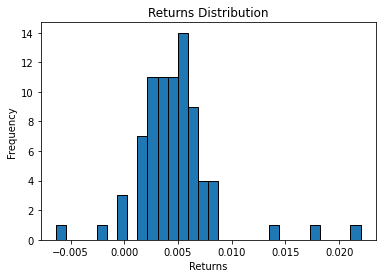

In [4]:
# Print Portfolio data
print(f"Portfolio: {PORTFOLIO} \nN. Stock: {nStocks}")
print(f"From: {time.iloc[0, 0]} To: {time.iloc[-1, 0]}")

plt.hist(ret_mean, bins=30, edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Returns Distribution')
plt.show()

In [5]:
#Choose x1 in C
def generate_random_array(n):
    random_nums = np.random.rand(n)
    total = np.sum(random_nums)
    random_array = random_nums / total
    return random_array

## Markovitz Efficient Frontier

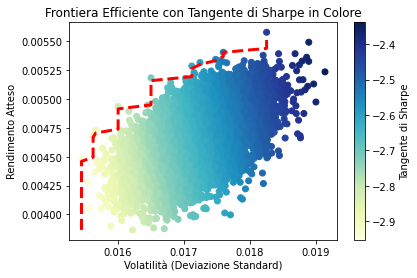

In [6]:
# Dati di esempio
mean_returns = ret_mean  # Rendimenti attesi per due asset
cov_matrix = cov  # Matrice di covarianza
weights_maxret = []
vol_maxret = 0
ret_maxret = 0

# Creazione di portafogli random
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    #weights = generate_random_array(nStocks)
    weights = np.random.random(nStocks)
    weights /= np.sum(weights)
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev

    if portfolio_return > ret_maxret:
        weights_maxret = weights
        ret_maxret = portfolio_return
        vol_maxret = portfolio_stddev

    
    # Tangente di Sharpe (assumendo tasso privo di rischio di 0.05)
    results[2,i] = (portfolio_return - 0.05) / portfolio_stddev

# Estrazione dei portafogli sulla frontiera efficiente
return_range = np.linspace(min(results[0]), max(results[0]), 50)
frontier = []
for ret in return_range:
    subset = results[1][results[0] > ret]
    if subset.size > 0:
        idx = np.argmin(subset)
        frontier.append([subset[idx], ret])

frontier = np.array(frontier).T

# Plot
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Frontiera Efficiente con Tangente di Sharpe in Colore')
plt.xlabel('Volatilità (Deviazione Standard)')
plt.ylabel('Rendimento Atteso')
plt.colorbar(label='Tangente di Sharpe')
plt.plot(frontier[0], frontier[1], 'r--', linewidth=3)
plt.show()

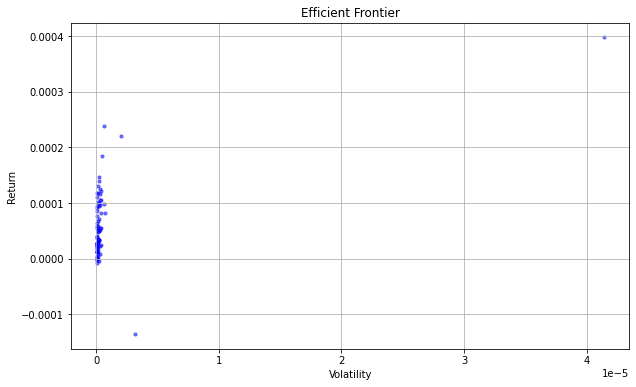

In [7]:
port_returns = []
port_volatility = []

for idx, w in enumerate(weights):
    port_returns.append(np.dot(w, ret_mean[idx]))

port_volatility = np.diag(np.dot(np.dot(cov, np.diag(weights)), cov.T))

plt.figure(figsize=(10, 6))
plt.scatter(port_volatility, port_returns, marker='o', color='b', s=10, alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()

# Portfolio Optimizations

We have $n$ avaiable assets. We call $w_i$ the quantity of money invested on the
$i$-th asset during the considered period and with $r_i$ the returns on the $i$-th
asset. We have two different constraints. The first one is non-negativity for the
variables (i.e., $w_i$ ≥ 0). It basically means that short selling (selling asset that
we still don’t own) is not allowed. We then have the budget constraint:

$
\begin{equation}
\sum_{i=1}^{n} w_i = B
\end{equation}
$



the total amount of money invested needs to be equal to the budget $B$ ($B$ can be simply set to 1).
Consider a stochastic model for the returns: $r ∈ R^n$ is a randomly generated vector with mean $\overline{r}$ and covariance $\Sigma$. Thus expected return will be:
$
\begin{equation}
\overline{r}^\intercal \, w
\end{equation}
$
and variance (risk)
$
\begin{equation}
w^\intercal \, \Sigma \, w
\end{equation}
$
Classic portfolio problem, described by Markowitz (1952), is a convex quadratic programming problem:
$
\begin{equation}
\begin{split}
\underset{w∈R^n}{min} \quad \gamma \, w^\intercal \, \Sigma \, w - \overline{r}^\intercal \, w \\
s.t. \quad e^\intercal w = 1 \\
w > 0
\end{split}
\end{equation} 
$
with $\gamma$ > 0 risk-aversion parameter. Goal is thus finding the set of assets that
minimizes the variance (risk connected to the given portfolio) while maximizing
the expected return (we obviously need to satisfy budget and non-negativity
constraints).

In [8]:
def checkMeanRet(weights):
    return np.dot(ret_mean.T, weights)

def checkSumOne(weights):
    return np.sum(weights) - 1

In [9]:
def riskFunction(weights):
    return np.dot(w.T, np.dot(cov, weights))

def loss(weights):
    return  np.dot(RISK_AVERSION, np.dot(weights.T, np.dot(cov, weights))) -  np.dot(ret_mean.T, weights)

## Hessian and Lipschitz constant

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.

In [10]:
def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
    
def is_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

In [12]:
%%time
#print("Hessian matrix")
#hessian = nd.Hessian(loss)(weights)

# Let C convex set and f convex function over C 
# Every local minimum of f over C is also global minimum

# Let C convex set and f convex function over C 
# If x is a local minimum of f over C it is also the only local and global 
# minimum for f over C

# Strong convexity is used for providing linear convergence
# rate of many gradient descent based algorithms
print("Calculating sigma (strongly convex)")
##sigma = is_strongly_convex(hessian)
#is_sc = sigma > 0

#if is_sc: print(f"Sigma: {sigma}, strongly convex")
#else: print(f"Sigma: {sigma}, not strongly convex")

#L = lipschitz_constant(hessian)
#print(f"Lipschitz constant: {L}")

#print("Lipschitz constant for single variable")
#Li = np.repeat(L, len(hessian))

Calculating sigma (strongly convex)
CPU times: user 37 µs, sys: 23 µs, total: 60 µs
Wall time: 47.2 µs


## Gradient

$
\begin{equation}
\nabla f(w_k) = 2 \, \gamma \, \Sigma \, w - \overline{r}^\intercal\\
\end{equation} 
$

In [11]:
def gradient(w):
    return  RISK_AVERSION * 2 * np.dot(w, cov) -  ret_mean.T

# Projected Gradient, Frank-Wolfe and Pairwise Frank-Wolfe over the Markowitz portfolio problems

## Projected Gradient Method

In [12]:
def project_onto_simplex(y):
    m = len(y)
    bget = False
    s = sorted(y, reverse=True)
    tmpsum = 0.

    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1)
        if tmax >= s[ii+1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m
        
    return np.maximum(y-tmax,0.)


In [13]:
%%time

ITERATIONS = 11

weights = generate_random_array(nStocks)
weights_x = np.ones(nStocks) / nStocks
loss_values_pgd = []
grad_values_pgd = []
returns_iteration_pgd = []
optimal_indices_pgd = []
optimal_values_pgd = []
optimal_weights_pgd = []

loss_pgd_improved = [loss(weights)]
ret_pgd_improved = [checkMeanRet(weights)]

prev_loss = float('inf')

for itr in range(1, ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights)

    # Store values for plotting
    loss_values_pgd.append(loss(weights))
    grad_values_pgd.append(np.linalg.norm(grad))
    returns_iteration_pgd.append(checkMeanRet(weights))
    
    step_size = 1 / (itr + 1) #CONTROLLA 
    weights_new = weights - step_size * grad    
    current_loss = loss(weights_new)
    
    norm_update = np.linalg.norm(weights_new - weights)
    if abs(prev_loss - current_loss) < 1e-6:
        print('Break itr: ', itr)
        break

    weights = project_onto_simplex(weights_new)
    prev_loss = current_loss

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_pgd[-1])*100:05.2f}% - loss {loss(weights):05.2f}")

print("Final Weights: ", weights[:7])
def second_largest_partition(arr):
    return np.partition(arr, -2)[-2]

print(f"Sec Max Weights: {second_largest_partition(weights)}")
print(f"Max Weights: {np.max(weights)}")
print("Sum weights: ", np.sum(weights))

Final Weights:  [0.02017057 0.00277172 0.01914688 0.0139212  0.02837172 0.00210883
 0.        ]
Sec Max Weights: 0.028371723935420964
Max Weights: 0.04825113740226945
Sum weights:  1.0000000000000002
CPU times: user 2.6 ms, sys: 2.25 ms, total: 4.85 ms
Wall time: 3.45 ms


In [14]:
data = {
    'Returns': returns_iteration_pgd,
}

df = pd.DataFrame(data)
df

,Returns
0,0.004379
1,0.004872
2,0.005161
3,0.005377
4,0.005549
5,0.005692
6,0.005813
7,0.005913
8,0.006003
9,0.006083


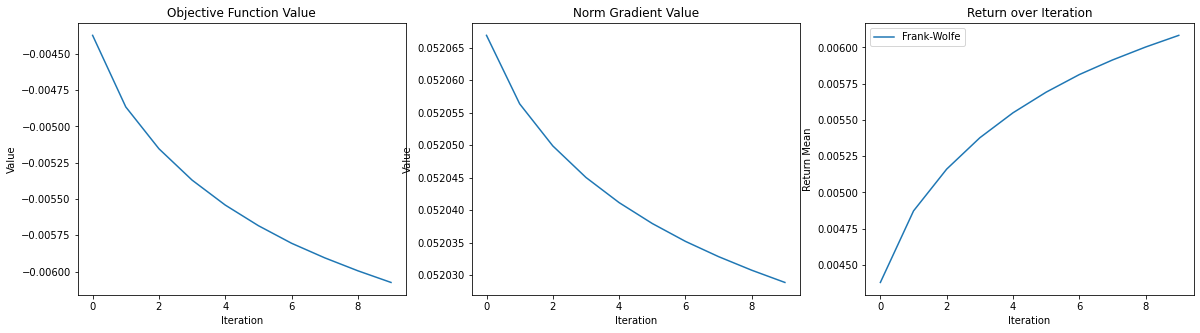

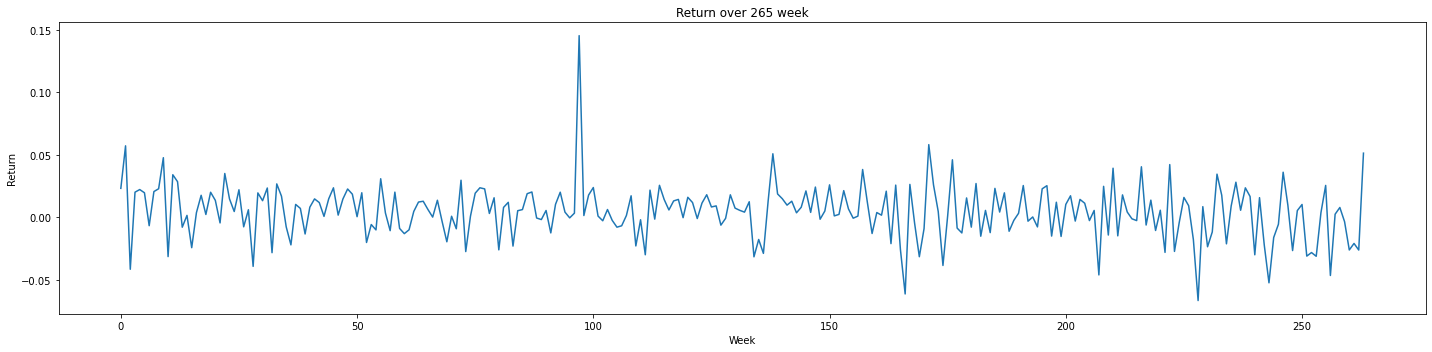

Final weights: [0.02017057 0.00277172 0.01914688 0.0139212 ]
Sum of weights: 1.0000000000000002
Return Portfolio:  0.6156493431432524 %
Risk:  0.042509319274967636 %


In [15]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

# Loss Function Values
plt.subplot(1, 3, 1)
plt.plot(loss_values_pgd)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 3, 2)
plt.plot(grad_values_pgd)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_pgd, label='Frank-Wolfe')
#plt.plot(solval_k5[0], label='Solution Retuns')
plt.title('Return over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Return Mean')
plt.legend()

# Return over 264 weeks
ret_mean_weeks_pgd = np.dot(ret_time, weights)

plt.figure(figsize=(20, 5))
plt.plot(ret_mean_weeks_pgd)
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')

plt.tight_layout()
plt.show()

ret_mean_pgd = checkMeanRet(weights) * 100
print("Final weights:", weights[:4])
print("Sum of weights:", np.sum(weights))
print('Return Portfolio: ', ret_mean_pgd, "%")
print('Risk: ', np.dot(weights.T, np.dot(cov, weights))*100, "%")

## Frank-Wolfe Method

In [16]:
def linear_solver(grad):
    c = grad # Use the positive gradient for minimization
    A_eq = np.ones((1, nStocks))
    b_eq = np.array([1])
    bounds = [(0, 1) for _ in range(nStocks)]
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    return res.x

def duality_gap(weights, grad):
    """
    Compute the duality gap for the given weights and gradient.
    """
    s = linear_solver(grad)
    return np.dot(grad, weights - s)

In [17]:
%%time

ITERATIONS = 20

weights = generate_random_array(nStocks)
weights_x = np.ones(nStocks) / nStocks
loss_values_fw = []
grad_values_fw = []
returns_iteration_fw = []
optimal_indices_fw = []
optimal_values_fw = []
optimal_weights_fw = []

loss_gd_improved = [loss(weights)]
ret_gd_improved = [checkMeanRet(weights)]

prev_loss = float('inf')

for itr in range(1, ITERATIONS):
    if itr % (ITERATIONS * 0.05) == 0:
        print(f"{int(itr/ITERATIONS*100):02}%", end="")

    grad = gradient(weights)
    s = linear_solver(grad)
    direction = s - weights

    # Store values for plotting
    loss_values_fw.append(loss(weights))
    grad_values_fw.append(np.linalg.norm(grad))
    returns_iteration_fw.append(checkMeanRet(weights))

    # Find the indices of the components with the maximum value in the direction
    max_value = np.max(direction) # or np.min(direction) depending on the context
    optimal_values_fw.append(max_value)
    optimal_indices = np.where(direction == max_value)[0]
    optimal_indices_fw.append(optimal_indices.tolist())

    if abs(duality_gap(weights, grad)) < 1e-6: 
        print('Duality Gap Convergence itr: ', itr)
        break
    
    step_size = 2 / (itr + 2) #CONTROLLA 
    weights_new = weights + step_size * direction    
    current_loss = loss(weights_new)

    optimal_weights_fw.append(np.max(weights_new))
    
    #norm_update = np.linalg.norm(weights_new - weights)
    #if abs(prev_loss - current_loss) < 1e-6:
    #    print('Break itr: ', itr)
    #    break

    weights = weights_new
    prev_loss = current_loss

    if itr % (ITERATIONS * 0.05) == 0:
        print(f" - ret {(returns_iteration_fw[-1])*100:05.2f}% - loss {loss(weights):05.2f}")

def second_largest_partition(arr):
    return np.partition(arr, -2)[-2]

print(f"Sec Max Weights: {second_largest_partition(weights)}")
print(f"Max Weights: {np.max(weights)}")
print("Sum weights: ", np.sum(weights))

05% - ret 00.43% - loss -0.02
10% - ret 01.61% - loss -0.02
15% - ret 01.91% - loss -0.02
20% - ret 02.02% - loss -0.02
25% - ret 02.08% - loss -0.02
30% - ret 02.12% - loss -0.02
35% - ret 02.14% - loss -0.02
40% - ret 02.15% - loss -0.02
45% - ret 02.16% - loss -0.02
50% - ret 02.17% - loss -0.02
55% - ret 02.17% - loss -0.02
60% - ret 02.18% - loss -0.02
65% - ret 02.18% - loss -0.02
70% - ret 02.18% - loss -0.02
75% - ret 02.18% - loss -0.02
80% - ret 02.19% - loss -0.02
85% - ret 02.19% - loss -0.02
90% - ret 02.19% - loss -0.02
95% - ret 02.19% - loss -0.02
Sec Max Weights: 0.00011292555643287605
Max Weights: 0.995282079850457
Sum weights:  0.9999999999999998
CPU times: user 43.7 ms, sys: 18.4 ms, total: 62.1 ms
Wall time: 43.7 ms


In [18]:
data = {
    'Returns': returns_iteration_fw,
    'Index i Optimal Sol': optimal_indices_fw,
    'Optimal Weights FW': optimal_weights_fw
}

df = pd.DataFrame(data)
df

,Returns,Index i Optimal Sol,Optimal Weights FW
0,0.004333,[12],0.669746
1,0.016107,[12],0.834873
2,0.019051,[12],0.900924
3,0.020228,[12],0.933949
4,0.020817,[12],0.952821
5,0.021153,[12],0.964616
6,0.021363,[12],0.972479
7,0.021503,[12],0.977983
8,0.021602,[12],0.981986
9,0.021673,[12],0.984988


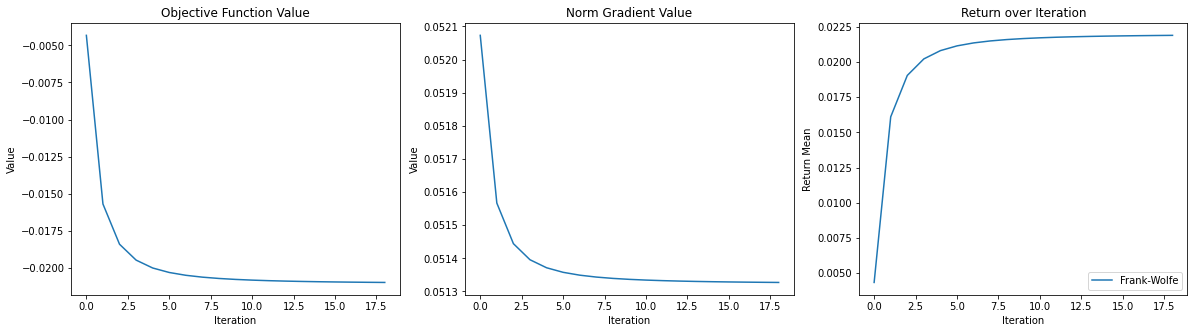

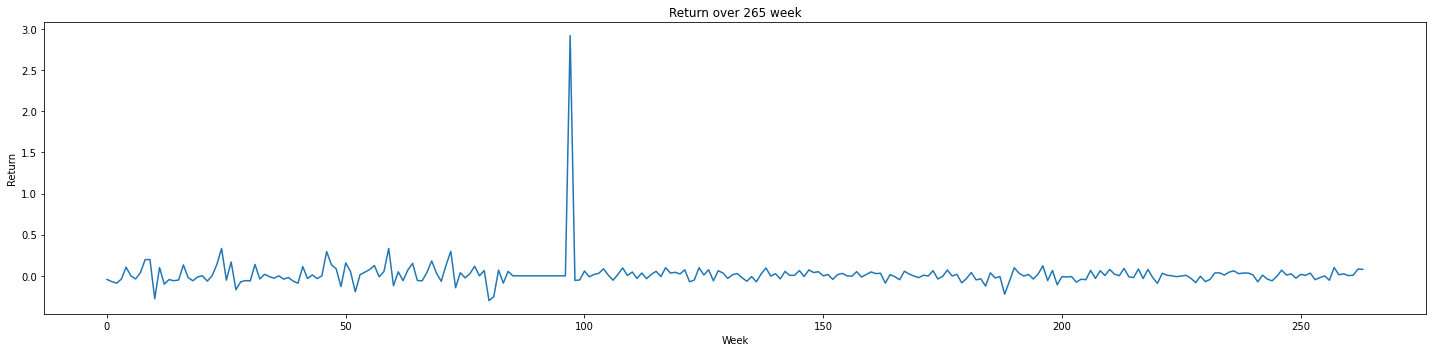

Final weights: [3.37491361e-05 9.19830457e-05 1.02104773e-04 7.14346323e-05]
Sum of weights: 0.9999999999999998
Return Portfolio:  2.190986865345863 %
Max ret mean:  0.02199396715
Risk:  4.728 %


In [19]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

# Loss Function Values
plt.subplot(1, 3, 1)
plt.plot(loss_values_fw)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Norm Gradient Values
plt.subplot(1, 3, 2)
plt.plot(grad_values_fw)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_fw, label='Frank-Wolfe')
#plt.plot(solval_k5[0], label='Solution Retuns')
plt.title('Return over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Return Mean')
plt.legend()

# Return over 264 weeks
ret_mean_weeks_fw = np.dot(ret_time, weights)

plt.figure(figsize=(20, 5))
plt.plot(ret_mean_weeks_fw)
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')

plt.tight_layout()
plt.show()

ret_mean_fw = checkMeanRet(weights) * 100
risk_fw = np.dot(weights.T, np.dot(cov, weights))*100

print("Final weights:", weights[:4])
print("Sum of weights:", np.sum(weights))
print('Return Portfolio: ', ret_mean_fw, "%")
print('Max ret mean: ', np.max(ret_mean))
print("Risk: ", np.round(risk_fw,3), "%")

## Pairwise Frank-Wolfe

In [20]:
def pairwise_fw_update(grad, w):
    """
    Compute the Pairwise Frank-Wolfe direction.
    """
    # Identifying the two components of the gradient to modify
    i = np.argmax(grad)
    j = np.argmin(grad)
    
    # Constructing the direction vector
    d = np.zeros_like(grad)
    d[i] = -w[i]
    d[j] = 1-w[j]
    
    return d

In [21]:
%%time
ITERATIONS = 11

# Initialize weights and other parameters
weights = generate_random_array(nStocks)

loss_values_pairwise = []
grad_values_pairwise = []
returns_iteration_pairwise = []
optimal_indices_pairwise = []
optimal_values_pairwise = []
prev_loss = float('inf')

for itr in range(1, ITERATIONS):
    grad = gradient(weights)
    direction = pairwise_fw_update(grad, weights)
    
    # Store values for plotting
    loss_values_pairwise.append(loss(weights))
    grad_values_pairwise.append(np.linalg.norm(grad))
    returns_iteration_pairwise.append(checkMeanRet(weights))

    # Find the indices of the components with the maximum value in the direction
    max_value = np.max(direction) # or np.min(direction) depending on the context
    optimal_values_pairwise.append(max_value)
    optimal_indices = np.where(direction == max_value)[0]
    optimal_indices_pairwise.append(optimal_indices.tolist())

    if abs(duality_gap(weights, grad)) < 1e-6: 
        print('Duality Gap Convergence itr: ', itr)
        break

    step_size = 2 / (itr + 2) #CONTROLLA
    weights_new = weights + step_size * direction
    weights_new /= np.sum(weights_new) # Normalizing the updated weights
    
    current_loss = loss(weights_new)
    
    #norm_update = np.linalg.norm(weights_new - weights)
    #if norm_update < 1e-6 or abs(prev_loss - current_loss) < 1e-6:
    #    print('Break itr: ', itr)
    #    break
    
    weights = weights_new
    prev_loss = current_loss

print("Final Weights: ", weights[:4])
print(f"Max Weights: {np.max(weights)}")
print("Sum weights: ", np.sum(weights))



Final Weights:  [0.00026176 0.00297274 0.00587494 0.00146536]
Max Weights: 0.764377814008707
Sum weights:  0.9999999999999996
CPU times: user 12.1 ms, sys: 2.37 ms, total: 14.4 ms
Wall time: 12.5 ms


In [22]:
data = {
    'Returns': returns_iteration_pairwise,
    'Index i Optimal Sol': optimal_indices_pairwise,
    'Optimal Values PFW': optimal_values_pairwise
}

df_pairwise = pd.DataFrame(data)
df_pairwise

,Returns,Index i Optimal Sol,Optimal Values PFW
0,0.004730,[12],0.978538
1,0.011661,[12],0.589589
2,0.014039,[12],0.454677
3,0.015272,[12],0.384451
4,0.016040,[12],0.340657
5,0.016570,[12],0.310375
6,0.016962,[12],0.287986
7,0.017265,[12],0.270638
8,0.017509,[12],0.256724
9,0.017709,[12],0.245263


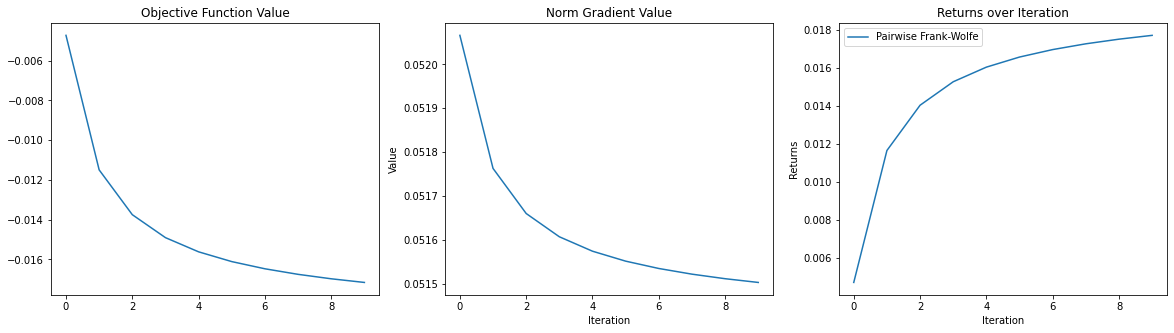

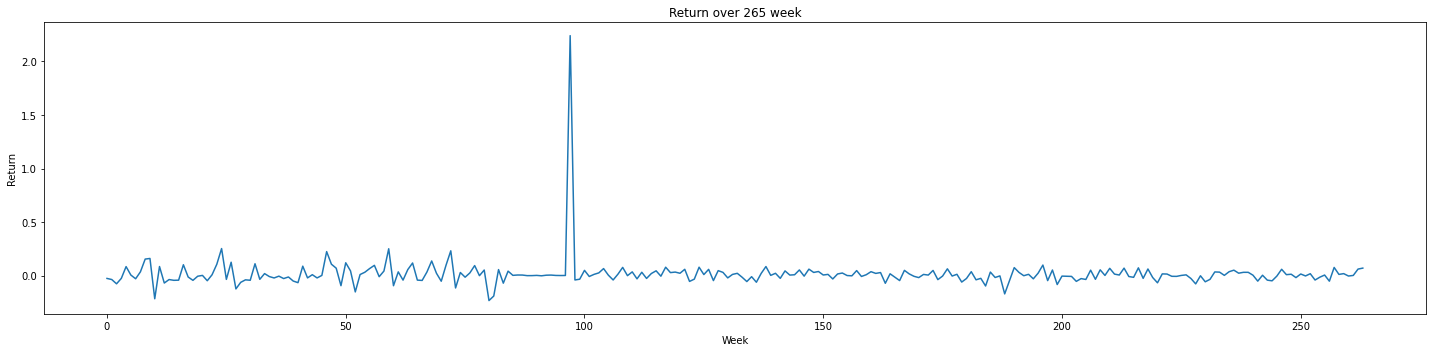

Final weights: (79,)
Sum of weights: 0.9999999999999996
Return Portfolio:  1.787767296897232 %


In [23]:
# Plotting the metrics
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_values_pairwise)
plt.title('Objective Function Value')

plt.subplot(1, 3, 2)
plt.plot(grad_values_pairwise)
plt.title('Norm Gradient Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_pairwise, label='Pairwise Frank-Wolfe')
#plt.plot(solval_k5[0], label='Solution')
plt.title('Returns over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Returns')
plt.legend()

# Return over 264 weeks
ret_mean_weeks_pairwise = np.dot(ret_time, weights)

plt.figure(figsize=(20, 5))
plt.plot(ret_mean_weeks_pairwise)
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')


plt.tight_layout()
plt.show()

ret_mean_pairwise = checkMeanRet(weights) * 100
print("Final weights:", weights.shape)
print("Sum of weights:", np.sum(weights))
print('Return Portfolio: ', ret_mean_pairwise, "%")

# Comparison

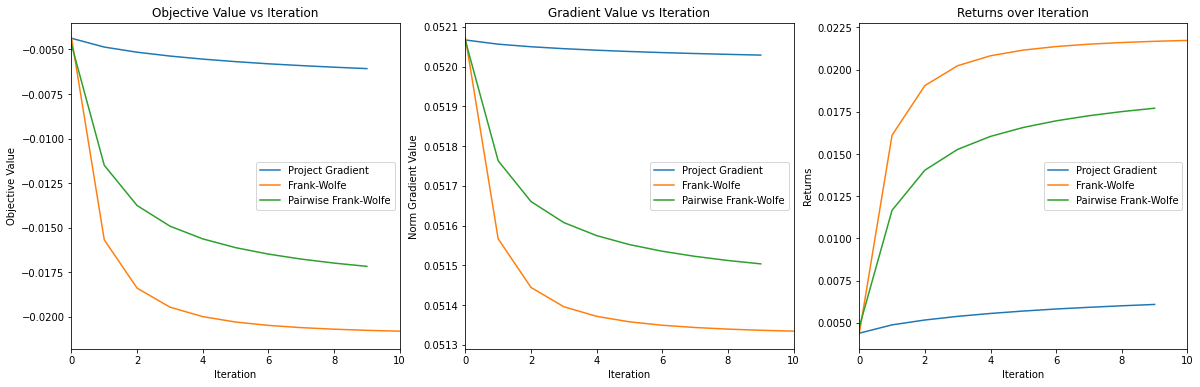

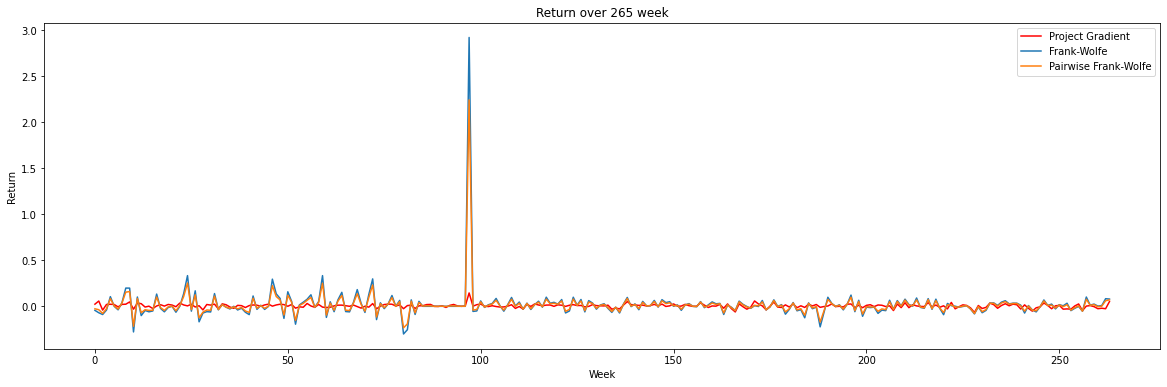

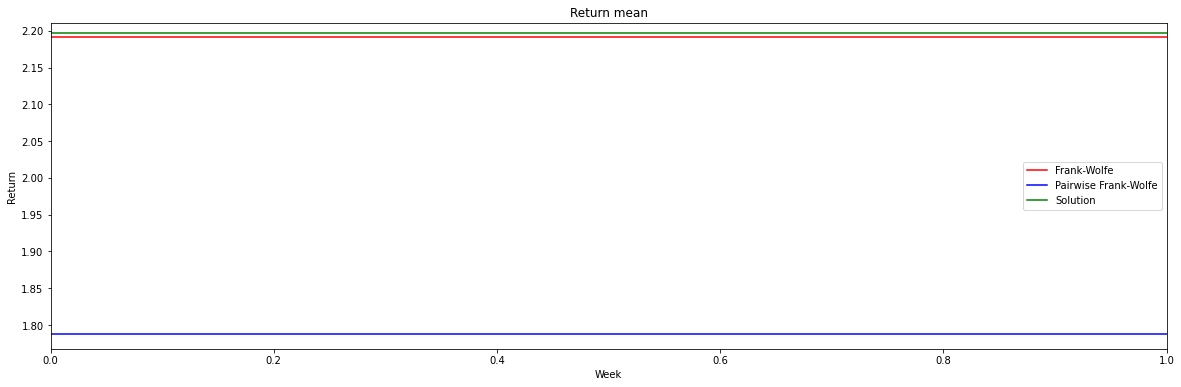

In [28]:
# Plotting Objective Values for both methods
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(loss_values_pgd, label='Project Gradient')
plt.plot(loss_values_fw, label='Frank-Wolfe')
plt.plot(loss_values_pairwise, label='Pairwise Frank-Wolfe')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value vs Iteration')
plt.xlim(0,10)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(grad_values_pgd, label='Project Gradient')
plt.plot(grad_values_fw, label='Frank-Wolfe')
plt.plot(grad_values_pairwise, label='Pairwise Frank-Wolfe')
plt.xlabel('Iteration')
plt.ylabel('Norm Gradient Value')
plt.title('Gradient Value vs Iteration')
plt.xlim(0,10)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(returns_iteration_pgd, label='Project Gradient')
plt.plot(returns_iteration_fw, label='Frank-Wolfe')
plt.plot(returns_iteration_pairwise, label='Pairwise Frank-Wolfe')
#plt.plot(solval_k5[0], label='Solution')
plt.title('Returns over Iteration')
plt.xlabel('Iteration')
plt.ylabel('Returns')
plt.xlim(0,10)
plt.legend()

# Return over 264 weeks
ret_mean_weeks = np.dot(ret_time, weights)

plt.figure(figsize=(20, 6))
plt.plot(ret_mean_weeks_pgd, label='Project Gradient', color='r')
plt.plot(ret_mean_weeks_fw, label='Frank-Wolfe')
plt.plot(ret_mean_weeks_pairwise, label='Pairwise Frank-Wolfe')
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')
plt.legend()

# Return mean
plt.figure(figsize=(20, 6))
plt.axhline(ret_mean_fw, label='Frank-Wolfe', color='r')
plt.axhline(ret_mean_pairwise, label='Pairwise Frank-Wolfe', color='b')
plt.axhline(list(solval_k5[0])[-1]*100, label='Solution', color='g')
plt.title('Return mean')
plt.xlabel('Week')
plt.ylabel('Return')
plt.legend()
plt.show()

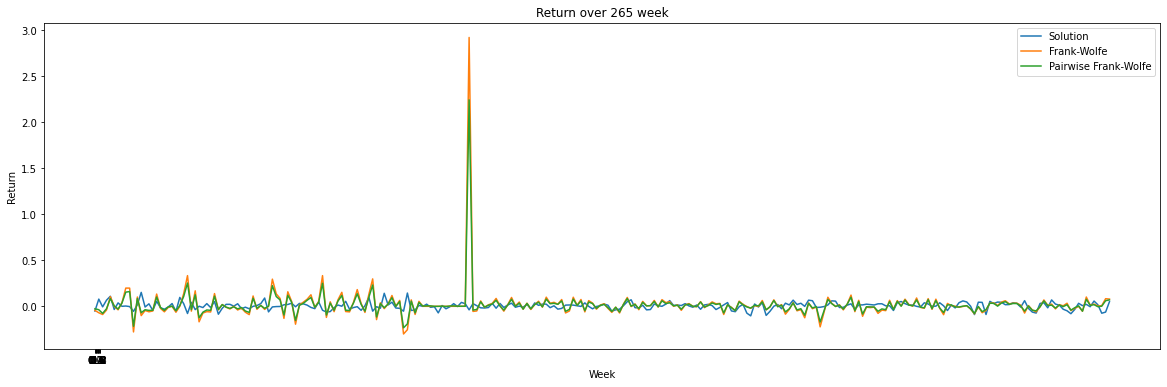

In [25]:
weights_sol = np.zeros(nStocks)
#weights_sol[22] = 0.989851
weights_sol[3] = 0.989851
weights_sol[38] = 0.010149

# Return over 264 weeks
ret_mean_weeks = np.dot(ret_time, weights)
ret_mean_weeks_sol = np.dot(ret_time, weights_sol)

plt.figure(figsize=(20, 6))
plt.plot(ret_mean_weeks_sol, label='Solution')
plt.plot(ret_mean_weeks_fw, label='Frank-Wolfe')
plt.plot(ret_mean_weeks_pairwise, label='Pairwise Frank-Wolfe')
plt.title('Return over 265 week')
plt.xlabel('Week')
plt.ylabel('Return')

plt.xticks(np.arange(0, 251, 10))
plt.xticks(np.arange(0, 1.4, 0.1))

plt.legend()
plt.show()